# Tutorial

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import hucira as hc

import warnings
from tqdm import TqdmWarning

warnings.simplefilter("ignore", TqdmWarning)

import time
start = time.time()

/lustre/groups/ml01/workspace/jenni.liu/conda_extern/envs/hucira/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cytokine-induced Immune Programs

From the Human Cytokine Dictionary, we derived 82 Cytokine-induced Immune Programs (CIP). This tutorial guides you through the enrichment analysis of these gene sets. Your query data should be a transcriptomic data object in AnnData's .h5ad format with gene symbols in .var axis and metadata describing immune celltypes and experimental conditions of samples.

# 1. Load input data

The two main input files for this tool are:
1. the Cytokine-induced Immune Programs (CIP)
2. your transcriptome data object

Explore their metadata annotation for cell types and disease condition.

In [2]:
#### Load the file containing our derived cytokine-induced immune programs

cip_sig = hc.load_CIP_signatures()

print(f"All celltypes in signatures:\n  {cip_sig.celltype.unique()}")
print("\n")
print(f"All CIP in signatures:\n  {cip_sig.CIP.unique()}")
cip_sig

Loading from: /ictstr01/home/icb/jenni.liu/all_projects/cytokine_dict_project/huCIRA/docs/notebooks/CIP_signatures.csv
All celltypes in signatures:
  ['Treg' 'CD4_T_cell' 'CD8_T_cell' 'cDC' 'MAIT' 'CD14_Mono' 'CD16_Mono'
 'B_cell' 'NK_CD56hi' 'NK_CD56low' 'NKT' 'HSPC']


All CIP in signatures:
  ['MD-05 CellInteraction' 'CS-05 ImmuneReg' 'PD-05 BcellAct'
 'CS-03 MixedCytokine' 'CS-04 Recruitment-3' 'II-10 Complement'
 'SN-04 NeuralComm' 'FC-06 ImmuneMod' 'TR-02 TissueRepair'
 'MD-06 IntegrinSignal' 'II-01 PatternRecog' 'MD-08 TissueRemodel'
 'II-19 MonoStress' 'II-23 cDC-Suppress' 'II-20 MyeloidMetab'
 'ES-01 OxidativeStress' 'SN-03 SynapticSignal' 'FC-01 ScavengerComp'
 'FC-07 Phagocytosis' 'II-27 ChemokineRemodel' 'CS-09 ECM'
 'II-02 PathogenSense' 'II-03 ImmuneHomeo' 'TR-04 AntiInflam'
 'II-04 MyeloidActive' 'II-05 ViralResponse' 'II-06 AntiInflam'
 'GR-01 lncRNA-Reg' 'GR-04 CellSignal' 'GR-02 GeneExpStress'
 'IT-02 IonChannel' 'II-11 InnateActive' 'PD-03 BcellDiff-1'
 'II-14 MonoAc

,gene,CIP,effect_size,celltype
0,MEOX1,MD-05 CellInteraction,0.120686,Treg
1,MEOX1,MD-05 CellInteraction,0.120686,CD4_T_cell
2,MEOX1,MD-05 CellInteraction,0.120686,CD8_T_cell
3,MEOX1,MD-05 CellInteraction,0.120686,cDC
4,MEOX1,MD-05 CellInteraction,0.120686,MAIT
...,...,...,...,...
104131,HNF1B,PD-11 BcellSignal,0.166682,B_cell
104132,ENSG00000286277,PD-11 BcellSignal,0.112509,B_cell
104133,ENSG00000286364,PD-11 BcellSignal,0.563512,B_cell
104134,ENSG00000286546,PD-11 BcellSignal,0.253321,B_cell


In [3]:
#### Load the query adata object

adata = hc.load_MS_CSF_data()
adata

Loading from: /ictstr01/home/icb/jenni.liu/all_projects/cytokine_dict_project/huCIRA/docs/notebooks/MS_CSF.h5ad


AnnData object with n_obs × n_vars = 65326 × 10266
    obs: 'labels', 'MS', 'CSF', 'valid_clusters', 'CD4_labels'
    obsm: 'X_umap'

In [4]:
#### Optional for easy workflow:
# Enter celltype column name and condition column name

your_celltype_colname = "labels"
your_contrast_colname = "MS"


# Check data size (Are the conditions you want to contrast of comparable size?)
adata.obs[your_contrast_colname].value_counts()

MS
True     35483
False    29843
Name: count, dtype: int64

In [5]:
# Enrichment analysis needs two main information from query adata: cell types and disease conditions.
# They have to be chosen manually, because annotation of objects differs.

print(f"All celltypes in query data:\n  {sorted(adata.obs[your_celltype_colname].unique())}\n")
print(f"All experimental states (contrasts/conditions) in query data:\n  {sorted(adata.obs[your_contrast_colname].unique())}\n")

All celltypes in query data:
  ['B cell doublets', 'B1', 'B2', 'CD4', 'CD8a', 'CD8n', 'Gran', 'MegaK', 'Mono', 'Mono Doublet', 'NK1', 'NK2', 'RBC', 'Tdg', 'Tregs', 'contamination1', 'doublet', 'mDC1', 'mDC2', 'ncMono', 'pDC', 'plasma']

All experimental states (contrasts/conditions) in query data:
  ['False', 'True']



# 2. Process and prepare input data parameters

1. Convert ENSG to gene symbols if necessary
2. Because there is no standard nomenclature for cell types, we have to manually create **"celltype_combos"**, the data container that matches the cell types of your query data to the cell types in the CIP.
3. Choose the experimental conditions of interest (**"contrasts"**)

In [6]:
#### Create celltype_combos. An input parameter for the enrichment analysis.

adata_celltypes = ["B1", "CD8a", "Mono"]
CIP_celltypes = ["B_cell", "CD8_T_cell", "CD14_Mono"]

celltype_combos = hc.create_celltype_combos(adata_celltypes, CIP_celltypes)
celltype_combos

(('B1', 'B_cell'), ('CD8a', 'CD8_T_cell'), ('Mono', 'CD14_Mono'))

In [7]:
#### Define conditions of interest:

contrasts = [("True", "False")]

# 3. Run enrichment analysis

The main analysis is done by run_one_enrichment_test(), which computes enrichment scores of one query celltype and different conditions. 
This simple example returns an example of the main outcome of this cytokine enrichment score analysis. <br>

1. *run_one_enrichment_test()* returns enrichment results for one celltype and contrast.
2. *get_robust_significant_results()* returns the robust and significant results from that initial enrichment analysis.


In [8]:
enrichment_results = hc.run_one_enrichment_test(
    adata=adata,
    df=cip_sig,
    contrasts_combo=contrasts,
    celltype_combo=celltype_combos[0],
    contrast_column=your_contrast_colname,
    celltype_column=your_celltype_colname,
    direction="upregulated",
    threshold_lfc=1.0,
    threshold_expression=0.05,
    threshold_pval=0.01
)

enrichment_results[
    [
        "celltype_combo",
        "CIP",
        "contrast",
        "direction",
        "ES",
        "NES",
        "NOM p-val",
        "FDR q-val",
        "FWER p-val",
        "frac_shared_genes_signature",
    ]
].sort_values("NES", ascending=False)

Computing gene sets of Cytokine-induced gene programs for B_cell.
Using precomputed stats
True_vs_False


,celltype_combo,CIP,contrast,direction,ES,NES,NOM p-val,FDR q-val,FWER p-val,frac_shared_genes_signature
0,B1 (B_cell),PD-05 BcellAct,True_vs_False,upregulated,0.554781,1.95207,0.0,0.0,0.0,0.508380
1,B1 (B_cell),PD-08 BcellProlif,True_vs_False,upregulated,0.517229,1.912568,0.0,0.0,0.0,0.268102
2,B1 (B_cell),PD-11 BcellSignal,True_vs_False,upregulated,0.546199,1.798589,0.0,0.0,0.0,0.358025
3,B1 (B_cell),FC-05 IgE-Humoral,True_vs_False,upregulated,0.424371,1.583758,0.001056,0.001586,0.006,0.386700
4,B1 (B_cell),PD-03 BcellDiff-1,True_vs_False,upregulated,0.372912,1.499887,0.0,0.005288,0.022,0.301955
5,B1 (B_cell),PD-04 BcellReg,True_vs_False,upregulated,0.369261,1.498489,0.0,0.004583,0.023,0.262981
6,B1 (B_cell),PD-10 Transcriptional,True_vs_False,upregulated,0.330519,1.28669,0.024896,0.046533,0.24,0.340220


In [9]:
#### Lastly, get robust and significant results from previous enrichment_results

robust_results_dict = hc.get_robust_significant_results(
    results=enrichment_results,
    alphas=[0.1, 0.05, 0.01],
    threshold_valid=0.1,
    threshold_below_alpha=0.9,
    display_df_nicely=True,
)

100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.89it/s]

Contrast:True_vs_False


celltype_combo,B1 (B_cell)
CIP,
FC-05 IgE-Humoral,1.583758
PD-03 BcellDiff-1,1.499887
PD-04 BcellReg,1.498489
PD-05 BcellAct,1.952070
PD-08 BcellProlif,1.912568
PD-10 Transcriptional,1.286690
PD-11 BcellSignal,1.798589


# 4. Visualization of results


 *run_all_enrichment_test()* iterates the enrichment analysis over several cell types and gene set thresholds for the enrichment analysis, resuting in more robust results. The output is ideal for visualization of:

1. Heatmaps, representing normalized enrichment scores and significant annotations.
2. Cell-cell communication plot, representing cell communication through cytokines.

In [10]:
#### Run more robust enrichment analysis on a several celltypes and conditions:

all_enrichment_results = hc.run_all_enrichment_test(
    adata=adata,
    df=cip_sig,
    contrasts_combo=contrasts,
    celltype_combos=celltype_combos,
    contrast_column=your_contrast_colname,
    celltype_column=your_celltype_colname,
    direction="upregulated",
    threshold_lfc=[0.8, 1],
    threshold_expression=[0.05, 0.01],
)

# Look at all enrichment results (reduced view to columns of interest, not all statistics)
all_enrichment_results[
    [
        "celltype_combo",
        "CIP",
        "contrast",
        "direction",
        "ES",
        "NES",
        "NOM p-val",
        "FDR q-val",
        "FWER p-val",
        "frac_shared_genes_signature",
    ]
].sort_values("NES", ascending=False)

Computing gene sets of Cytokine-induced gene programs for B_cell.
Using precomputed stats
True_vs_False
Computing gene sets of Cytokine-induced gene programs for B_cell.
Using precomputed stats
True_vs_False
Computing gene sets of Cytokine-induced gene programs for B_cell.
Using precomputed stats
True_vs_False
Computing gene sets of Cytokine-induced gene programs for B_cell.
Using precomputed stats
True_vs_False
Computing gene sets of Cytokine-induced gene programs for CD8_T_cell.


2025-12-20 00:55:08,455 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False
Computing gene sets of Cytokine-induced gene programs for CD8_T_cell.


2025-12-20 00:55:09,434 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False
Computing gene sets of Cytokine-induced gene programs for CD8_T_cell.


2025-12-20 00:55:10,420 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False
Computing gene sets of Cytokine-induced gene programs for CD8_T_cell.


2025-12-20 00:55:11,363 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False
Computing gene sets of Cytokine-induced gene programs for CD14_Mono.


2025-12-20 00:55:12,249 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False
Computing gene sets of Cytokine-induced gene programs for CD14_Mono.


2025-12-20 00:55:13,382 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False
Computing gene sets of Cytokine-induced gene programs for CD14_Mono.


2025-12-20 00:55:14,901 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False
Computing gene sets of Cytokine-induced gene programs for CD14_Mono.


2025-12-20 00:55:16,647 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False


,celltype_combo,CIP,contrast,direction,ES,NES,NOM p-val,FDR q-val,FWER p-val,frac_shared_genes_signature
0,CD8a (CD8_T_cell),CE-02 CellActive,True_vs_False,upregulated,0.667066,2.235164,0.0,0.0,0.0,0.627660
0,CD8a (CD8_T_cell),CE-02 CellActive,True_vs_False,upregulated,0.667066,2.235164,0.0,0.0,0.0,0.627660
0,CD8a (CD8_T_cell),CE-02 CellActive,True_vs_False,upregulated,0.683809,2.152049,0.0,0.0,0.0,0.760638
0,CD8a (CD8_T_cell),CE-02 CellActive,True_vs_False,upregulated,0.683809,2.152049,0.0,0.0,0.0,0.760638
1,CD8a (CD8_T_cell),CE-01 Cytotoxic-1,True_vs_False,upregulated,0.620282,2.119862,0.0,0.0,0.0,0.375000
...,...,...,...,...,...,...,...,...,...,...
3,Mono (CD14_Mono),II-13 InflamReg,True_vs_False,upregulated,-0.314762,-1.566444,0.0,0.139665,0.057075,0.246407
3,CD8a (CD8_T_cell),SN-02 SynapticAdhesion,True_vs_False,upregulated,-0.497492,-1.697427,0.0,0.008532,0.012077,0.445946
3,CD8a (CD8_T_cell),SN-02 SynapticAdhesion,True_vs_False,upregulated,-0.497492,-1.697427,0.0,0.008532,0.012077,0.445946
2,CD8a (CD8_T_cell),SN-02 SynapticAdhesion,True_vs_False,upregulated,-0.56604,-1.871217,0.0,0.003984,0.006944,0.310811


100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]

Contrast:True_vs_False


celltype_combo,B1 (B_cell),CD8a (CD8_T_cell),Mono (CD14_Mono)
CIP,,,
CE-01 Cytotoxic-1,NaN,2.043945,NaN
CE-02 CellActive,NaN,2.193607,NaN
CE-03 Cytotoxic-2,NaN,1.700025,NaN
CS-01 Recruitment-1,NaN,NaN,-0.198897
CS-02 Recruitment-2,NaN,NaN,1.178291
...,...,...,...
SN-02 SynapticAdhesion,NaN,-1.784322,-1.287101
SN-03 SynapticSignal,NaN,NaN,0.970276
TR-01 Type2Immune,NaN,1.255946,NaN


Contrast that was plotted in this example: True_vs_False


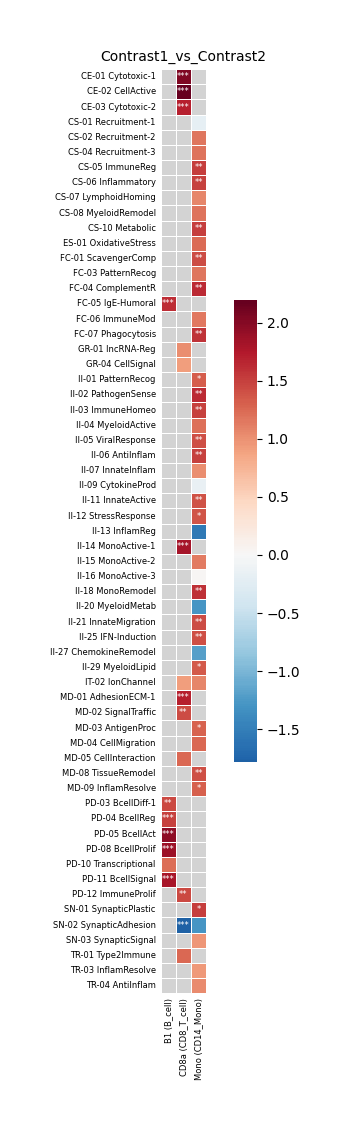

In [12]:
#### Create heatmap to visualize up-/down regulation of cytokines in all queried cell types for one contrast comparison.

robust_results_dict = hc.get_robust_significant_results(
    results=all_enrichment_results,
    alphas=[0.1, 0.05, 0.01],
    threshold_valid=0.1,
    threshold_below_alpha=0.9,
    display_df_nicely=True,
)


contrast_one = all_enrichment_results.contrast.unique()[0]  # Can be looked up manually
print(f"Contrast that was plotted in this example: {contrast_one}")

hc.plot_significant_results(
    results_pivot=robust_results_dict[contrast_one][0],
    df_annot=robust_results_dict[contrast_one][1],
    fontsize=6,
    save_fig=False,
    fig_path="",
    fig_width=18,
    fig_height=12
)

In [13]:
end = time.time()
print(f"Time: {int((end - start) / 60)} min {int((end - start) % 60)} sec")

Time: 0 min 33 sec


In [ ]:
## --END-- ##